# Coordinate Pair-Up map generator

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import random
import math
import cv2
ON = 1

In [2]:
def compute_wall_direction_1(x_coor, y_coor, x_distance, y_distance, map, dir):
    temp_list = []
    if dir == 0: # go horizontal first
        map[ y_coor , x_coor + x_distance : x_coor+1] = 1
        map[ y_coor:y_coor + y_distance+1, x_coor + x_distance] = 1

    elif dir == 1: # go vertical first
        map[ y_coor: y_coor + y_distance+1,x_coor] = 1
        map[ y_coor+ y_distance, x_coor + x_distance : x_coor+1] = 1
    
    elif dir == 2: # go horizontal first
        map[ y_coor, x_coor + x_distance: x_coor+1] = 1
        map[ y_coor + y_distance : y_coor+1, x_coor + x_distance] = 1
         
    elif dir == 3: # go vertical first
        map[ y_coor + y_distance : y_coor+1, x_coor] = 1
        map[y_coor + y_distance, x_coor + x_distance: x_coor+1] = 1
    return map

In [3]:
def compute_wall_direction_2(x_coor, y_coor, x_distance, y_distance, map, dir):
    if dir == 0: # go horizontal first
        map[ y_coor , x_coor:x_coor + x_distance+1] = 1
        map[ y_coor:y_coor + y_distance+1, x_coor + x_distance] = 1

    elif dir == 1: # go vertical first
        map[ y_coor: y_coor + y_distance+1,x_coor] = 1
        map[ y_coor+ y_distance, x_coor: x_coor + x_distance+1] = 1
    
    elif dir == 2: # go horizontal first
        map[ y_coor, x_coor : x_coor+ x_distance+1] = 1
        map[ y_coor + y_distance : y_coor+1, x_coor + x_distance] = 1
         
    elif dir == 3: # go vertical first
        map[ y_coor + y_distance +1 : y_coor, x_coor] = 1
        map[y_coor + y_distance, x_coor: x_coor + x_distance+1] = 1
    return map

In [4]:
def smooth_map(map_np):    
    filter = np.array([1, 0, 1])    
    filter2 = np.array([[1],[0],[1]])
    filter3 = np.array([[1],[0],[1]])
    for i in range(map_np.shape[0]):
        for j in range(map_np.shape[1]):
            if map_np[i][j] == 0:
                hor_array = map_np[i,j-1:j+2]                
                ver_array = map_np[i-1:i+2,j]
                
                if np.array_equiv(hor_array,filter) or np.array_equiv(ver_array,filter):
                    map_np[i][j] = 1
                # value = np.sum(new_array)
                # if value > 1:
                #     map_np[i][j] = 1
                    # print(new_array,value)
    return map_np

In [17]:
def fill_box(map):
    map = map.astype(np.uint8)*255
    contours = cv2.findContours(map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in contours:
        cv2.drawContours(map,[c], 0, (255,255,255), -1)
    map = map.astype(np.uint8)/255
    return map

In [27]:
#main program
CLR_MAP = {
    0: (0, 0, 0),  # black, wall
    1: (255, 255, 255),  # white, space/path
    2: (237, 28, 36),  # red, src
    3: (237, 28, 36),  # red, dest
    4: (255, 201, 14),  # blue violet, room
    5: (34, 177, 76),  # orange, route
    6: (255, 105, 180),  # hot pink, alternate main route
}

# initialize map
map_height = 100
map_width = map_height

# * height is y, width is x
# * so map_np[y,x]
# * origin point is at top left
init_map_np = np.zeros((map_height, map_width), dtype=np.uint8)

# border wall
# top
init_map_np[0, :] = 1
# bottom
init_map_np[map_height - 1, :] = 1
# left
init_map_np[:, 0] = 1
# right
init_map_np[:, map_width - 1] = 1

# map generation
map_np = init_map_np.copy()
rng = np.random.default_rng(12345)
random_size = 60
while True:
    wall_count = rng.integers(200, 250) #generate random wall number
    if wall_count % 2 == 0: # make sure those number is even number
        break

count = 0
x_coordinate = []
y_coordinate = []
wall_coordinate = []
rng.integers(low=1, high=map_height-1, size=(random_size))

#store all wall coordinates in a list
while (count < wall_count):
    wall_coordinate.append((rng.integers(low=1, high=map_width-1),rng.integers(low=1, high=map_height-1)))
    map_np[wall_coordinate[count]] = 1
    count += 1

#sort the coordinates x,y
wall_coordinate = sorted(wall_coordinate, key=lambda k: [k[1], k[0]])
paired_coordinate = []

#find the closest point for each coordinate and make them into pairs
while len(wall_coordinate) > 0:
    first_coordinate = wall_coordinate.pop(0)
    min_coordinate_index = 0
    for count, item in enumerate(wall_coordinate):
        if count == 0:
            continue
        cur_coordinate = wall_coordinate[count]
        cur_coordinate_distance = math.dist(
                    first_coordinate,
                    cur_coordinate)
        if count == 1 or cur_coordinate_distance <= min_coordinate_distance:            
            min_coordinate_distance = cur_coordinate_distance
            min_coordinate_index = count

    paired_coordinate.append(first_coordinate)
    paired_coordinate.append(wall_coordinate[min_coordinate_index])
    wall_coordinate.pop(min_coordinate_index)

paired_coordinate_copy = paired_coordinate.copy()

#compute line between 2 coordinates
while len(paired_coordinate_copy) > 0:
    first_pair = paired_coordinate_copy.pop(0)
    second_pair = paired_coordinate_copy.pop(0)
    x_distance = second_pair[1] - first_pair[1]
    y_distance = second_pair[0] - first_pair[0]
    random_dir = random.randrange(0, 2)
    #for 2 pairs, their position can seperate into 4 quadrants
    '''
    [[quadrants II, quadrants I],
    [quadrants III, quadrants IV]]
    '''
    if x_distance < 0:
        if y_distance > 0:
            #quadrants II
            map_np = compute_wall_direction_1(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir)
        elif y_distance < 0:
            #quadrants III
            map_np = compute_wall_direction_1(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir+2)
        else:
            map_np[first_pair[0],second_pair[1] : first_pair[1]+1] = 1 #just draw line
    elif x_distance > 0:
        if y_distance > 0:
            #quadrants I
            map_np = compute_wall_direction_2(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir)
        elif y_distance < 0:     
            #quadrants IV   
            map_np = compute_wall_direction_2(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir+2)            
        else:
            map_np[first_pair[0],first_pair[1] : second_pair[1]+1] = 1 #just draw line
    else: #if x is in the same line
        if y_distance < 0:
            map_np[second_pair[0] : first_pair[0] +1,first_pair[1]] =1 #just draw line
        else:            
            map_np[first_pair[0] : second_pair[0] +1,first_pair[1]] = 1 #just draw line

count = 0
map_np = smooth_map(map_np) #close up those gap which is only 1 pixel
#fill empty box
for count in range(4):
    if count == 0:
        map_np[0:50,0:map_width] = fill_box(map_np[0:50,0:map_width])
    if count == 1:
        map_np[50:map_height,0:map_width] = fill_box(map_np[50:map_height,0:map_width])
    if count == 2:
        map_np[0:map_height,0:50] = fill_box(map_np[0:map_height,0:50])
    if count == 3:
        map_np[0:map_height,50:map_width] = fill_box(map_np[0:map_height,50:map_width])
#check the whole map (except border) and fill empty box
map_np[1:map_height-1,1:map_np.shape[1]-1] = fill_box(map_np[1:map_height-1,1:map_width-1])
map_np[1:map_height-1,1:map_np.shape[1]-1] = fill_box(map_np[1:map_height-1,1:map_width-1])

## Define and calculate fitness function

The idea behind this is to have relatively well distributed obstacles across all 4 sectors of the map. Ideally, we would have a 35:65 obstacle to path ratio throughout the map, as such, cross entropy is used to compare the distribution of obstacles from the algorithm to the ideal distribution. Additionally, we purposely split the map into 4 sectors and calculate its average for this evaluation function is such that the distribution isn't too lopsided for any particular sector. I.e. the algorithm could hypothetically generate 35% of its cells as wall cells ONLY on the bottom right of the map, if we only calculate a general cross-entropy score for the entire map, we would not be able to determine whether there's anything wrong.

Steps for the fitness function:
1. Split the map into 4 equal sectors
2. Calculate the cross entropy for each sector against a targeted distribution of 35% walls, 65% open space
3. Obtain an average of the cross entropy values, the higher the average cross entropy, the worse the map generated

Cross entropy formula:
</br> 

![image.png](attachment:image-2.png)

In [31]:
def splitMap(map_np):
    #To split the map into 4 sectors, 
    #all we need to do is to split each axis by half
    height = map_np.shape[0]
    width = map_np.shape[1]
    
    height_midpoint = height//2
    width_midpoint = width//2
    return height_midpoint, width_midpoint

def crossEntropyEval(sector_np):
    # Takes in a slice of the usual map_np

    # First we calculate the total area of the sector:
    area = sector_np.shape[0] * sector_np.shape[1]
    wallCount = 0
    pathCount = 0
    
    # Next we obtain the number of wall cells and 
    # derive path cell count from it
    # Boundaries should not be included as part of sector_np
    for y in range(0,sector_np.shape[0]-1):
        for x in range(0,sector_np.shape[1]-1):
            if sector_np[y,x] == ON:
                wallCount += 1
    pathCount = area - wallCount

    crossEntropy = -(35/100*math.log(wallCount/area) + 65/100*math.log(pathCount/area))
    return crossEntropy


In [34]:
height_midpoint, width_midpoint =splitMap(map_np)

sector1 = map_np[1:height_midpoint, 1:width_midpoint]
sector2 = map_np[1:height_midpoint, width_midpoint:map_width-1]
sector3 = map_np[height_midpoint:map_height-1, 1:width_midpoint]
sector4 = map_np[height_midpoint:map_height-1, width_midpoint:map_width-1]

sectors = [sector1, sector2, sector3, sector4]

crossEntropySum = 0
for sector in sectors:
    crossEntropySum += crossEntropyEval(sector)

avgCrossEntropy = crossEntropySum/4
print(f"Evaluation score is: {avgCrossEntropy}")


Evaluation score is: 0.8325000163925448


# Plot the map

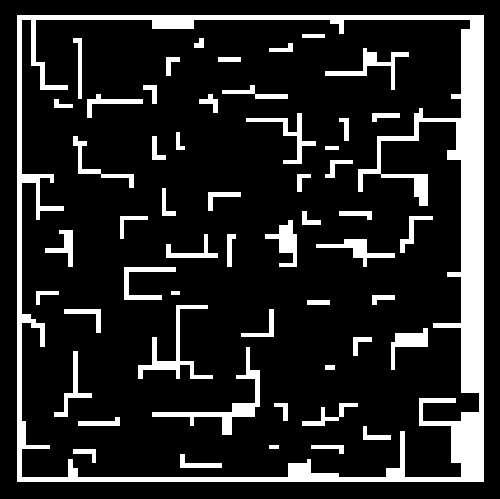

In [28]:
# convert to RGB Map
color_map_np = np.zeros((map_np.shape[0], map_np.shape[1], 3), dtype=np.uint8)

for y in range(map_np.shape[0]):
    for x in range(map_np.shape[1]):
        color = CLR_MAP[map_np[y, x]]
        color_map_np[y, x] = np.array(color)

plt.figure(facecolor='black')
plt.tight_layout()
plt.axis("off")   # turns off axes
plt.axis("tight")  # gets rid of white border
plt.axis("image")  # square up the image instead of filling the "figure" space
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlim([-2, map_width + 1])
plt.ylim([map_height + 1, -2])
plt.imshow(color_map_np, interpolation='nearest')
# plt.gcf().set_dpi(300)
# plt.savefig("test.png",bbox_inches='tight')
plt.show()

In [29]:
# output map
# Writing to file
with open("./map/dummy_map.txt", "w") as file:
    # Writing data to a file
    for y in range(map_np.shape[0]):
        # print(''.join(map(str,map_np[y, :].tolist())))
        file.write(''.join(map(str,map_np[y, :].tolist()))+'\n')


In [30]:
with open("./map/dummy_map.txt") as f:
    lines = f.readlines()
# check height & width
map_height = len(lines)
map_width = len(lines[0].strip())
map_repr = [ [0]*map_width for _ in range(map_height) ]
print(f"map_height: {map_height}")
print(f"map_width: {map_width }")

for y in range(len(lines)):
    line = lines[y].strip()
    for x in range(len(line)):
        map_repr[y][x] = int(line[x])

print(map_repr)


map_height: 100
map_width: 100
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0